## Face Detection (50 points)

### 1. Read this subset into the code environment and convert all images into grayscale.

Grid of the 100 pictures:


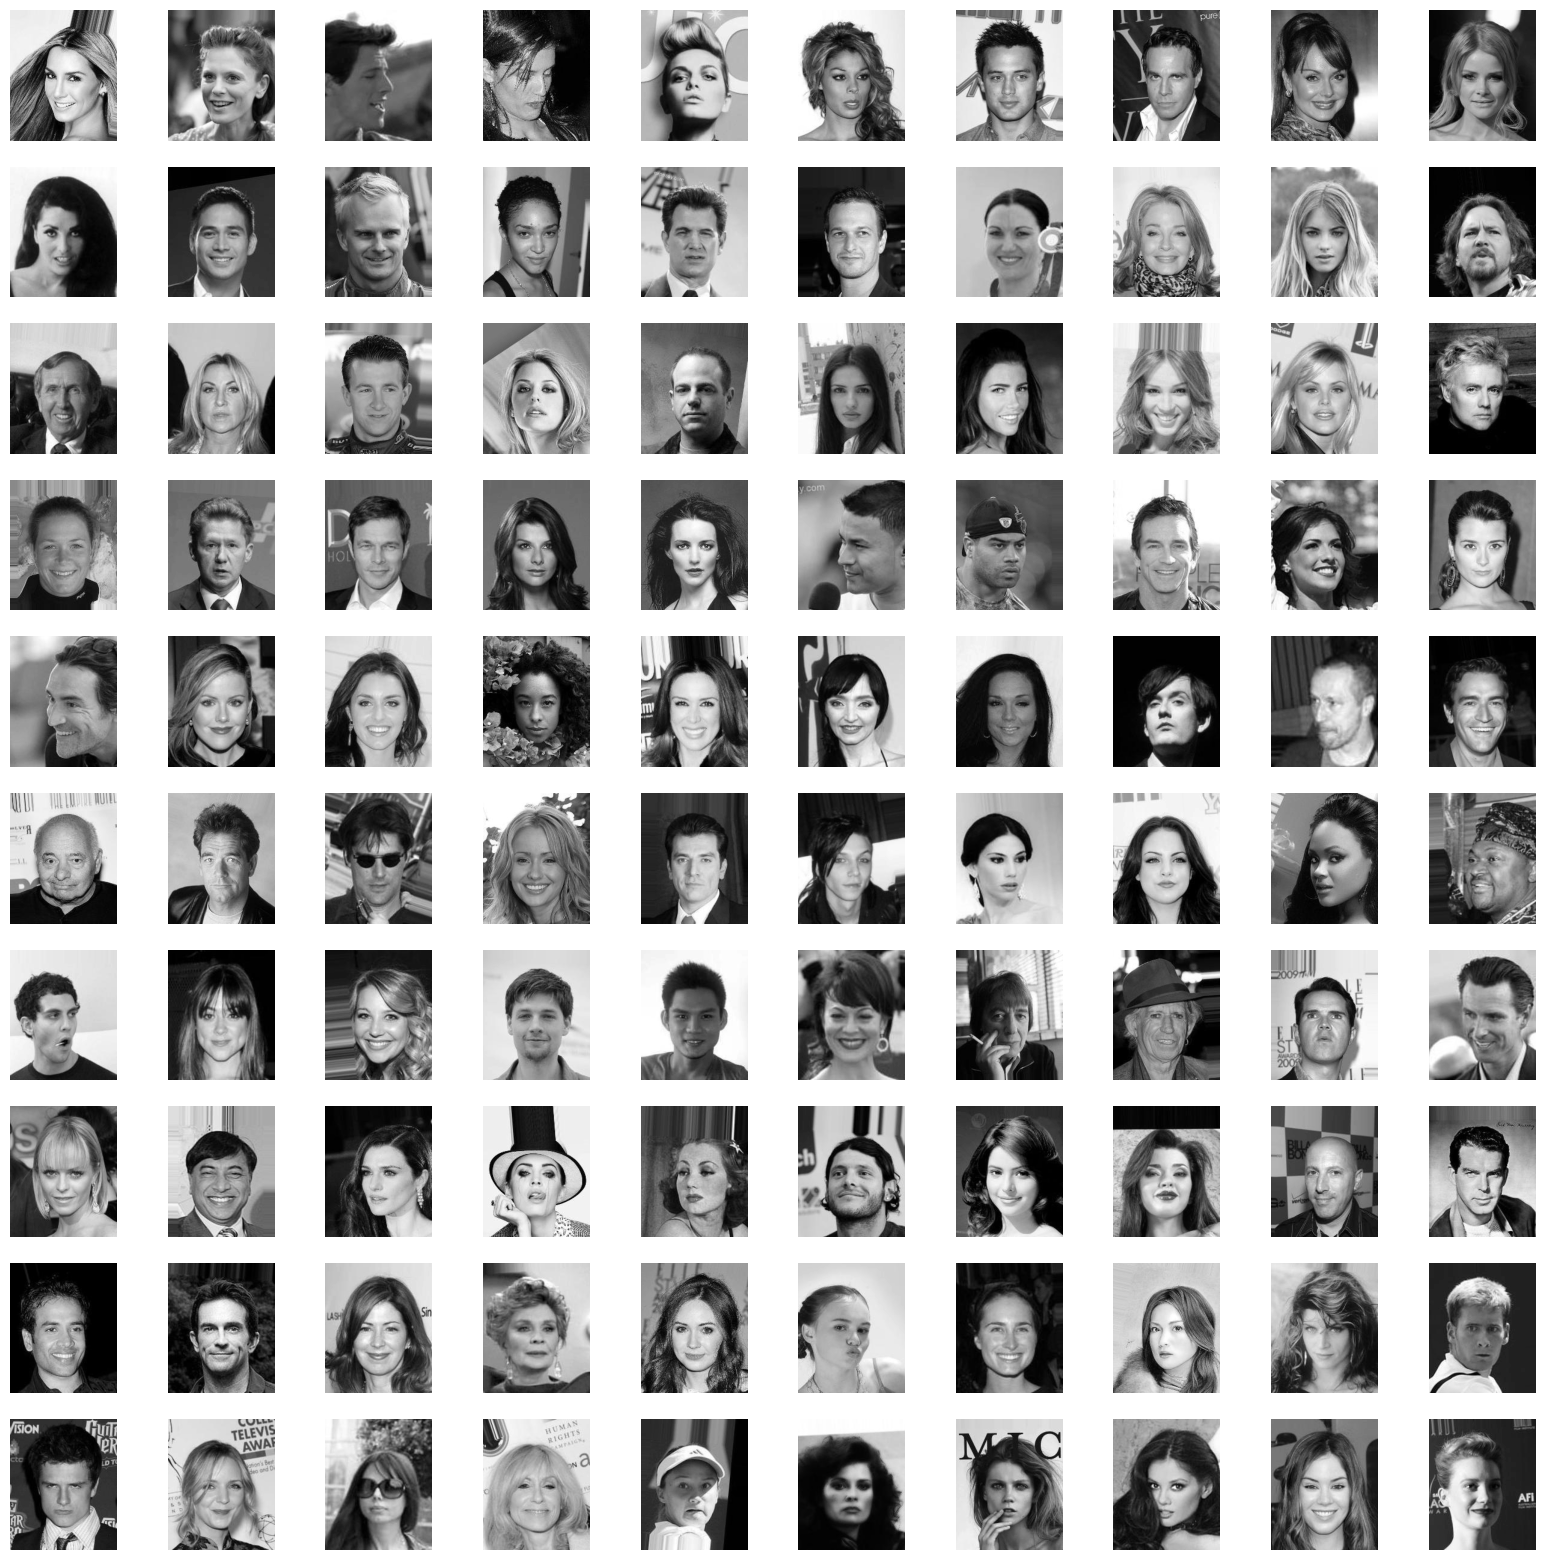

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# from google.colab import drive
# drive.mount('/content/drive')
# 
# path = '/content/drive/My Drive/ECSE415_computer_vision/A2/'
path = '/Users/theog/Documents/CodingProjects/ECSE415_Computer_Vision/Assignments/A3/A3-W24-images/'

# Empty list used to store the grayscale images
grayscale_images = []

# Load all images in the path and convert them to grayscale
for filename in os.listdir(path+'Q2 part1'):
  image = cv2.imread(os.path.join(path+'Q2 part1', filename))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  grayscale_images.append(gray)
  
# Convert the list to a numpy array
grayscale_images = np.array(grayscale_images)

#get the size of the training images:
height, width = grayscale_images[0].shape

print("Grid of the 100 pictures:")

# Display all the images in the list in a grid of 10x10
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
  for j in range(10):
    ax[i, j].imshow(grayscale_images[i*10 + j], cmap='gray')
    ax[i, j].axis('off')
plt.show()

### 2. Implement the Snapshot method for PCA (covered in Lecture 8, Slide 55) from scratch using Numpy. Display the first five face images.

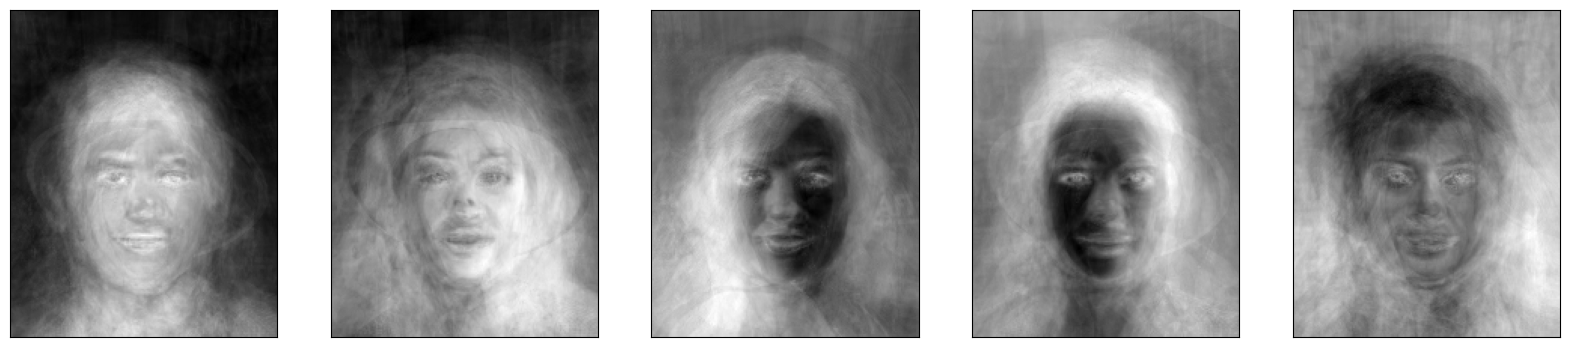

In [3]:
# # Flatten all the images by converting them to vectors 
image_vectors = grayscale_images.reshape(100, grayscale_images.shape[1]*grayscale_images.shape[2])

# Calculate mean and standard deviation along axis 0 (across all vectors)
mean_vector = np.mean(image_vectors, axis=0)
std_vector = np.std(image_vectors, axis=0)

# Normalize image vectors using broadcasting
D_matrix = (image_vectors - mean_vector) / std_vector

# Next we want to calculate the covraiance matrix
covariance_matrix = np.dot(D_matrix, D_matrix.T)

# Next we want the eignevalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

sorted_eigenvalues = np.argsort(np.abs(eigenvalues))[::-1]

# Get the eigenfaces:
eigenfaces = np.dot(D_matrix.T, eigenvectors)

# Select best 5 eigenfaces
best_5_eigenfaces = eigenfaces[:, sorted_eigenvalues[:5]]

# The weights are the projection of the image onto the eigenvectors
weights = np.dot(D_matrix, best_5_eigenfaces)

plt.figure(figsize=(20, 10))
for i in range(5):
  eigen_face = best_5_eigenfaces[:,i].reshape(height, width)
  plt.subplot(1, 5, i + 1)
  plt.imshow(eigen_face, cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

### 3. Use a sliding window method to detect faces in the image, which is named Person.png under folder Q2 part2. Use the result from the previous step to compute the distance in the eigenspace between the window #contents and your training data.

Person.png size: (1333, 2000)
Window size: (218, 178)


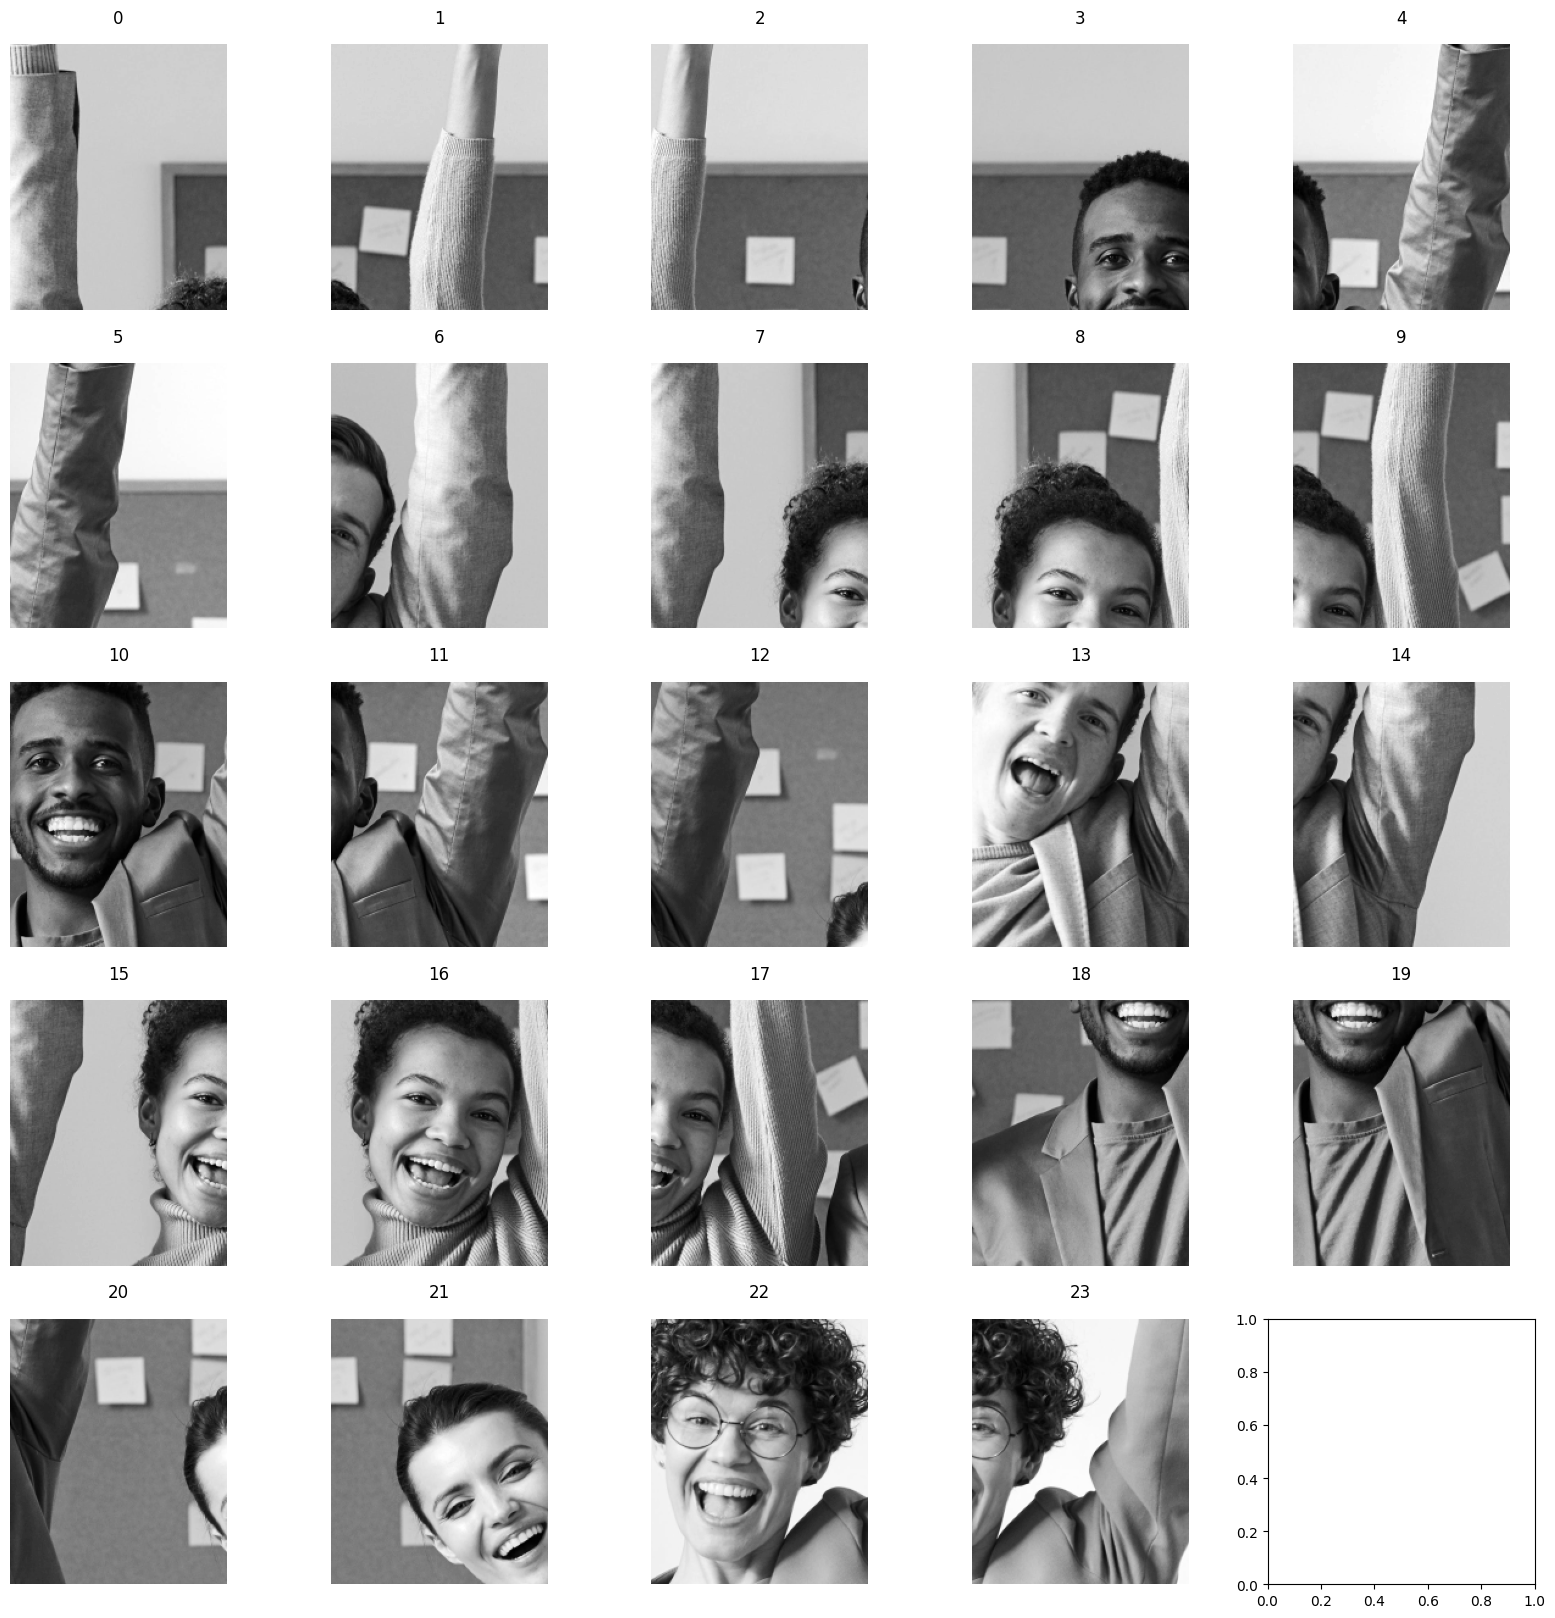

In [29]:
person_image = cv2.imread(path+'Q2 part2/Person.png')
person_image_gray = cv2.cvtColor(person_image, cv2.COLOR_BGR2GRAY)

# During testing, crop image to make computation faster
# person_image_gray = person_image_gray[800:-1500, :]
#display the cropped image
# print("Cropped image:")
# plt.imshow(person_image_gray, cmap='gray')
# plt.show()

#resize image to be smaller:
person_image_gray = cv2.resize(person_image_gray, (person_image_gray.shape[1]//3, person_image_gray.shape[0]//3), interpolation = cv2.INTER_AREA)

# Empty list used to store the faces detected
detected_faces = []
# Window size is the same as our training images
window_size = (height, width)

# print size of Person.png size the window size:
print("Person.png size: " + str(person_image_gray.shape))
print("Window size: " + str(window_size))


# Empty list used to store the mean faces
mean_face_distances = []

threshold = 155000  # Threshold responsible to detect how close to the eigenfaces does the window have to be
variance_threshold = 2000  # Faces have lots of variance, so we can use this to filter out non-faces
height_threshold = 500  # Anything above this height is not a face

for y in range(0, person_image_gray.shape[0], window_size[0]//2):
  if y >= height_threshold:
    continue
  for x in range(0, person_image_gray.shape[1], window_size[1]//2):
    # Extract the window contents
    window = person_image_gray[y:y + window_size[0], x:x + window_size[1]]

    # If the window size is not correct, skip this window
    if window.shape[0] != window_size[0] or window.shape[1] != window_size[1]:
      continue

    # If the variance of the window is below the threshold, skip this window
    # print ("window variance: ", np.var(window))
    if np.var(window) < variance_threshold:
      continue

    # Flatten the window contents and normalize
    window_normalized = (window.flatten() - image_vectors.mean(axis=0))/image_vectors.std(axis=0)

    # Project the window onto the eigenfaces
    projected_window_coefficients = np.dot(best_5_eigenfaces.T, window_normalized)
    euclidean_distance = np.linalg.norm(weights - projected_window_coefficients, axis=1)

    if euclidean_distance.mean() < threshold:
      mean_face_distances.append(euclidean_distance.mean())
      detected_faces.append(window)
      # print("Face detected at: " + str(x) + ", " + str(y))
      # plt.imshow(window, cmap='gray')

#display the faces:
# Calculate the number of rows and columns for the grid
num_faces = len(detected_faces)

if num_faces > 0:
  num_cols = int(np.ceil(np.sqrt(num_faces)))
  num_rows = int(np.ceil(num_faces / num_cols))

  # Create a subplot with the calculated number of slots
  fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20))

  # Ensure ax is always a 2D array, even when num_faces is 1
  if num_faces == 1:
    ax = np.array([[ax]])

  # Calculate the variance of each detected face
  face_variances = [np.var(face) for face in detected_faces]

  # Plot the faces in the grid
  for i in range(num_rows):
    for j in range(num_cols):
      face_index = i * num_cols + j
      if face_index < num_faces:
        ax[i, j].imshow(detected_faces[face_index], cmap='gray')
        ax[i, j].text(0.5, 1.08, str(face_index), size=12, ha="center", transform=ax[i, j].transAxes)
        # ax[i, j].text(0.5, 1.15, "Variance: {:.2f}".format(face_variances[face_index]), size=10, ha="center", transform=ax[i, j].transAxes)
        ax[i, j].axis('off')

  plt.show()

else:
  print("No faces were detected.")

### 4. Set a threshold to detect faces and select the best-performed value. Show your fine-tuned process


As we can see in the above code I have set three different threshold values:
- threshold: responsible to detect how close to the eigenfaces does the window have to be
- variance_threshold: faces have lots of variance, so we can use this to filter out non-faces
- height_threshold: anything above this height is not a face (which corresponds to the bottom portion of the image since the origin of the image is in the top left)
- I have also set the window size to be the same as the training images
- I have also set the step size to be 1/2 of the window size to speed up the computation
- I have also resized the image to be 3 times smaller to speed up the computation

During testing to get the best result I did multiple things:
- Cropped the image to make computation faster
- Tried different threshold values, by increasing and decreasing the threshold values to see how it affects the result (I would start detecting too many windows as faces even though they were not faces, and then I would increase the threshold to filter out the non-faces)
- Added a variance threshold to filter out non-faces, this filtered out a lot of non-faces


### 5. Label the detected images with bound boxes and display the final result image with labels.


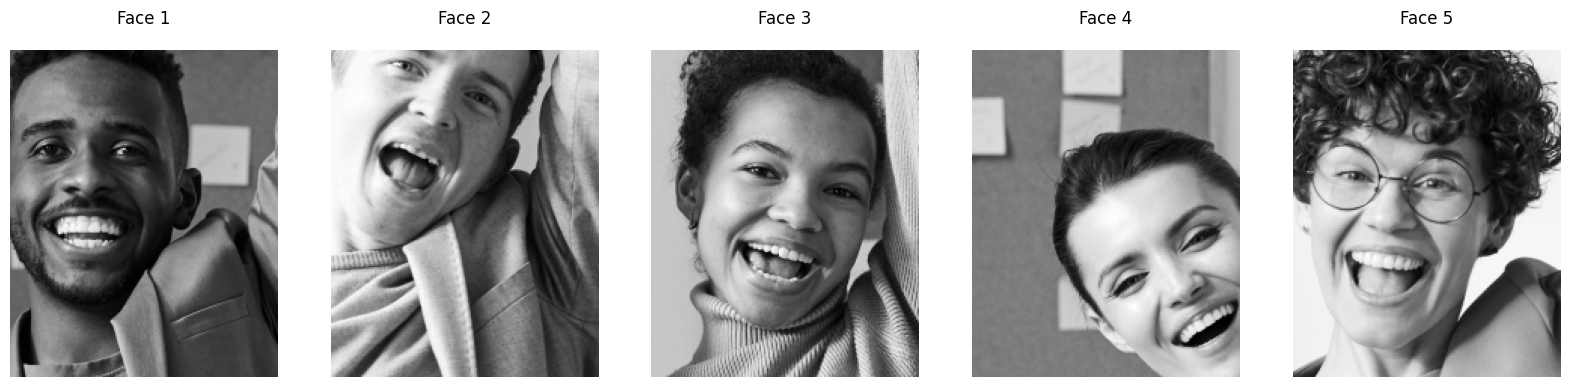

In [30]:
# List of image indices to display
image_indices = [10, 13, 16, 21, 22]

# Create a subplot with 1 row and as many columns as there are images
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

# Plot the images in a line
for i in range(5):
  ax[i].imshow(detected_faces[image_indices[i]], cmap='gray')
  ax[i].text(0.5, 1.08, "Face "+str(i+1), size=12, ha="center", transform=ax[i].transAxes)
  ax[i].axis('off')

plt.show()

### 6. Use an existing implementation of the Viola-Jones face detector to detect faces on the same image. Compare the result with the method you implemented.

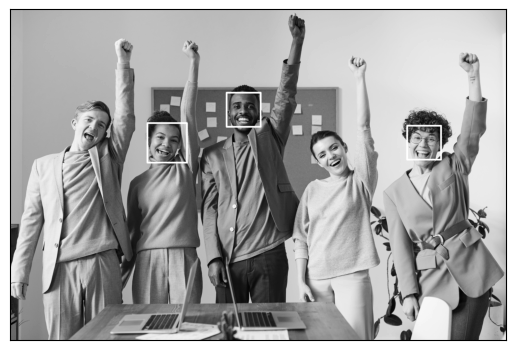

In [31]:
# Load the image
person_image_new = cv2.imread(path+'Q2 part2/Person.png')
person_image_new_gray = cv2.cvtColor(person_image_new, cv2.COLOR_BGR2GRAY)

# Based on Tutorial 5
face_cascade = cv2.CascadeClassifier(path+'Q2 part2/haarcascade_frontalface_default.xml')

# Set minimum size to avoid detecting small areas as faces
min_size = (300, 300)

faces = face_cascade.detectMultiScale(person_image_new_gray, 1.3, 5, minSize=min_size)

for (x,y,w,h) in faces:
  gray = cv2.rectangle(person_image_new_gray,(x,y),(x+w,y+h),(255,0,0),20)

plt.imshow(person_image_new_gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

### 7. Evaluate your predicted result in both methods(True/False, Positive/Negative)

In the PCA method with the selected parameters we get:
- True Positives: 5 (5/5 faces are detected)
- False Positives: 6 (If we consider windows that have no parts of a face as a false positive then we have 6)
- True Negatives: No value (since we are not detecting non-faces, but the number would be really big)
- False Negatives: 0 (All faces are detected)

In the Viola-Jones Detector with the selected parameters we get:
- True Positives: 3 (3/5 faces are detected)
- False Positives: 0 (with the parameters selected, no non-faces are detected as faces)
- True Negatives: No value (since we are not detecting non-faces, but the number would be really big)
- False Negatives: 2 (2/5 faces are not detected)

### 8. Explain under what conditions the Viola-Jones detector works when PCA does not.

The Viola-Jones Detector works better at clearly identifying the face and bounding it in the rectangle, whereas PCA grabs parts of the faces multiple times instead of one clear face. 
The Viola-Jones detector is also better at detecting faces that are not vertical and not tilted, but it struggles to detect the two faces that are sideways, whereas PCA is able to detect the sideways faces.
So the Viola-Jones detector would work better for real-time object detection as it can also be faster with integral images and by using Adaboost (as seen in lectures).

### 9. Evaluate the performance of this model and explain the steps that this network took to achieve the final result.

The Viola-Jones Detector relies on Haar-like features and a cascade of classifiers to efficiently detect objects, in our case faces.

Based on https://towardsdatascience.com/viola-jones-algorithm-and-haar-cascade-classifier-ee3bfb19f7d8, the Viola-Jones algorithm has the following steps:
1. Calculating Integral Image
2. Calculating Haar like features
3. AdaBoost Learning Algorithm
4. Cascade Filter

Limitations: ww notice that the Viola-Jones detector is really good at detecting faces that are vertical and not tilted, but it struggles to detect the two faces that are sideways. To check this, the following code rotates the image in different angles and tries to detect the faces in the image. 
We notice that when the sideways faces are rotated to be vertical, the Viola-Jones detector is able to detect them.  

Finished searching all combinations.


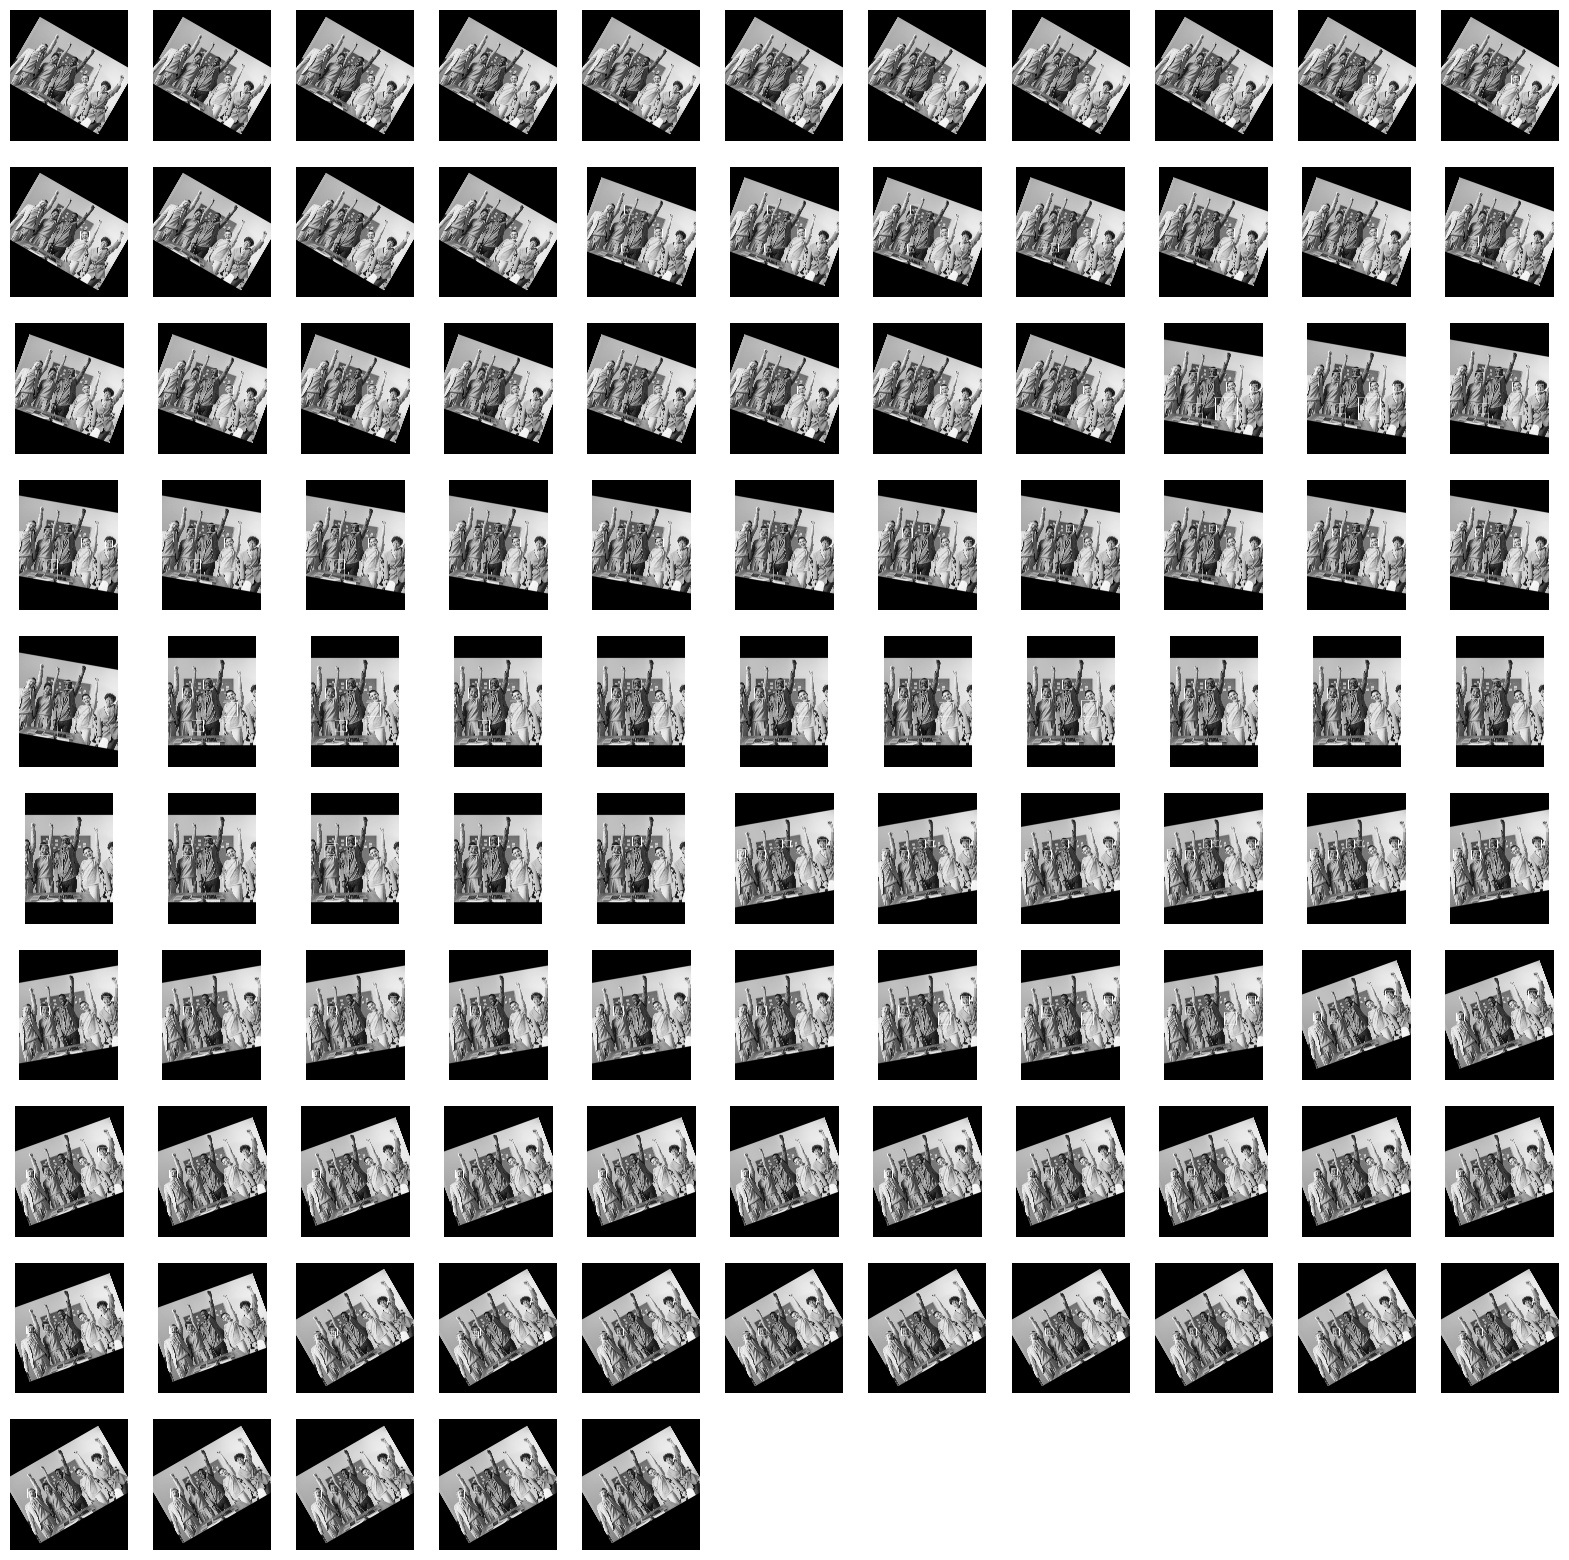

In [32]:
person_image_gray = cv2.imread(path+'Q2 part2/Person.png')
person_image_gray = cv2.cvtColor(person_image_new, cv2.COLOR_BGR2GRAY)

def rotate_image(image, angle):
  # Get the image size
  image_size = (image.shape[1], image.shape[0])
  image_center = tuple(np.array(image_size) / 2)

  # Get the rotation matrix
  rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

  # Update the translation part of the rotation matrix
  abs_cos = abs(rotation_mat[0,0])
  abs_sin = abs(rotation_mat[0,1])
  bound_w = int(image_size[0] * abs_sin + image_size[1] * abs_cos)
  bound_h = int(image_size[0] * abs_cos + image_size[1] * abs_sin)
  rotation_mat[0, 2] += bound_w/2 - image_center[0]
  rotation_mat[1, 2] += bound_h/2 - image_center[1]

  # Rotate the image
  rotated_image = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
  return rotated_image

def optimize_face_detection(image, face_cascade, min_size):
  # Define the range of values for scaleFactor and minNeighbors
  scale_factors = np.arange(1.1, 1.6, 0.1)
  min_neighbors = range(3, 6)

  # Define the angles for rotation
  angles = [-30, -20, -10, 0, 10, 20, 30]

  # List to store the images
  images = []

  # Iterate over all angles
  for angle in angles:
    # Rotate the image
    rotated_image = rotate_image(image, angle)

    # Iterate over all combinations of scaleFactor and minNeighbors
    for scale in scale_factors:
      for neighbors in min_neighbors:

        # Create a copy of the original image
        image_copy = np.copy(rotated_image)

        faces = face_cascade.detectMultiScale(image_copy, scaleFactor=scale, minNeighbors=neighbors, minSize=min_size)

        # If faces are detected
        if len(faces) > 0:
          # Print the parameters
          # print(f"scaleFactor: {scale}, minNeighbors: {neighbors}, Detected faces: {len(faces)}")

          # Draw rectangles around the faces
          for (x, y, w, h) in faces:
            cv2.rectangle(image_copy, (x, y), (x+w, y+h), (255, 0, 0), 20)

          # Add the image to the list
          images.append(image_copy)

  print("Finished searching all combinations.")

  # Calculate the number of rows and columns for the grid
  num_images = len(images)
  num_cols = int(np.ceil(np.sqrt(num_images)))
  num_rows = int(np.ceil(num_images / num_cols))

  # Create a subplot with the calculated number of slots
  fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20))

  # Ensure ax is always a 2D array, even when num_images is 1
  if num_images == 1:
    ax = np.array([[ax]])

  # Plot the images in the grid
  for i in range(num_rows):
    for j in range(num_cols):
      image_index = i * num_cols + j
      if image_index < num_images:
        ax[i, j].imshow(images[image_index], cmap='gray')
      ax[i, j].axis('off')

  plt.show()

  return None

# Call the function
faces = optimize_face_detection(person_image_gray, face_cascade, min_size)